In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2


In [2]:
#create DataFrame
df = pd.read_csv('../final_project/age_gender.csv')

In [137]:
#saving the dataframe for deployment
df0 = df.copy()
df0.to_pickle('df_og')

In [3]:
#changing the data type of the df.pixels columns & reshaping it
#sqrt of 2304 = 48
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

# Normalizing pixels data
df['pixels'] = df['pixels'].apply(lambda x: x/255)

#small list for easier visualization
gender_list = ['Male','Female']

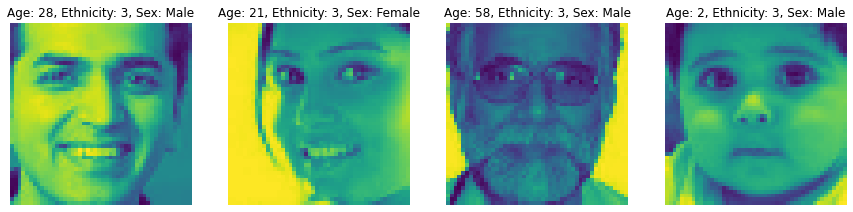

In [143]:
#A bit of visualization
fig, axes = plt.subplots(1, 4, figsize=(15, 10))

#choose 2 random pictures
for i in range(4):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = gender_list[df['gender'][random_face]]
    
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


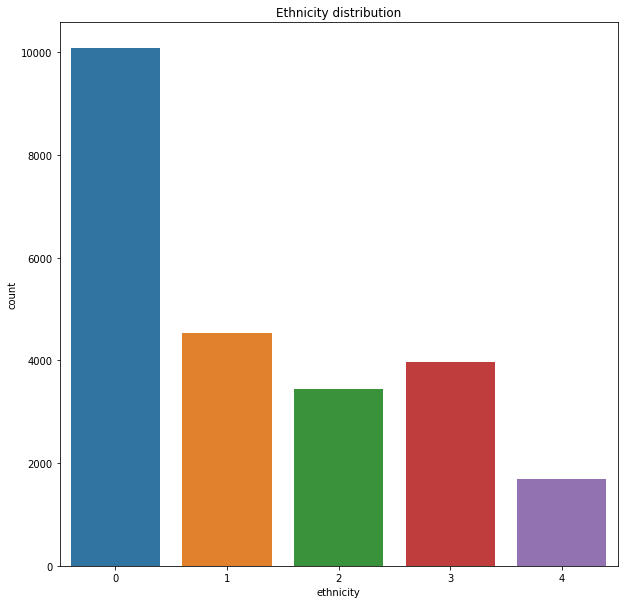

In [138]:
#visualizing the ethnicity distribution
plt.figure(figsize=(10,10))
plt.title('Ethnicity distribution')
sns.countplot(df.ethnicity);

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Gender distribution'}, xlabel='gender', ylabel='count'>

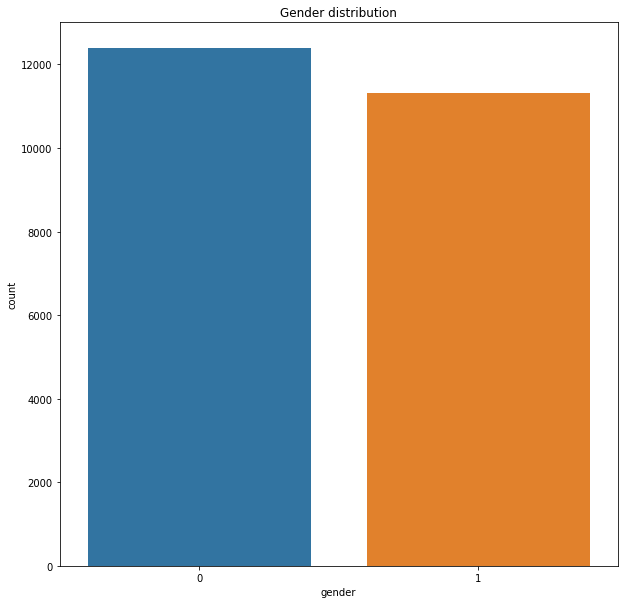

In [139]:
#visualizing the gender distribution
plt.figure(figsize=(10,10))
plt.title('Gender distribution')
sns.countplot(df.gender)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


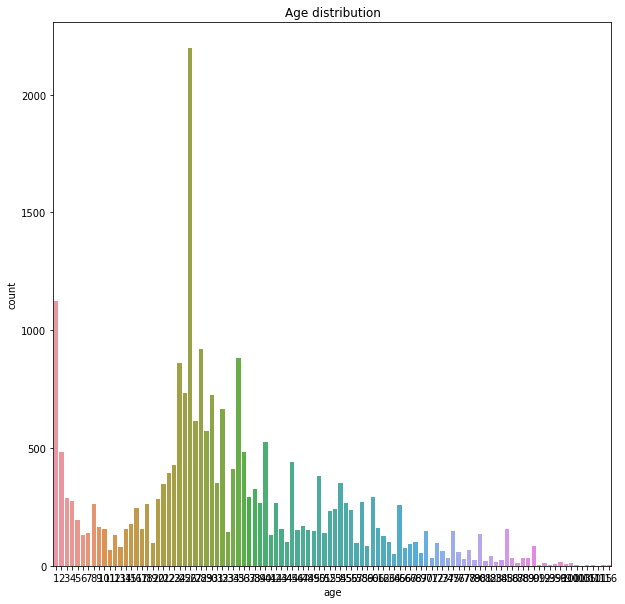

In [142]:
#visualizing the age distribution
plt.figure(figsize=(10,10))
plt.title('Age distribution')
sns.countplot(df.age);

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


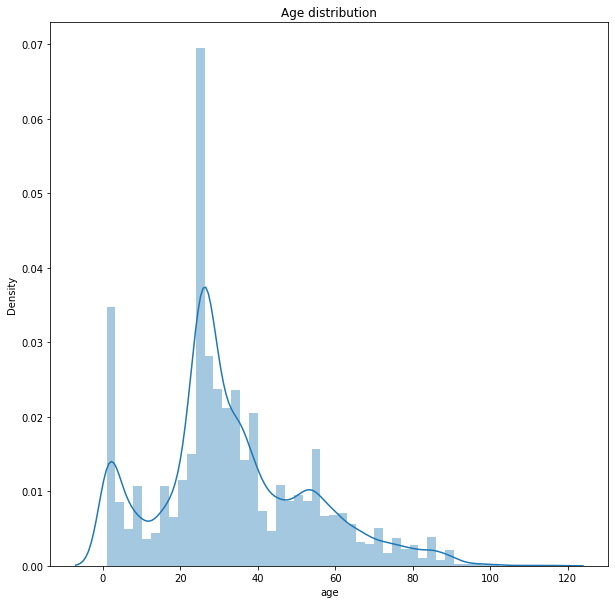

In [140]:
#visualizing the age distribution
plt.figure(figsize=(10,10))
plt.title('Age distribution')
sns.distplot(df.age);

In [8]:
#setting my variables
X = np.array(df['pixels'].to_list())
X = X.reshape(X.shape[0], 48, 48, 1)

y_age = np.array(df['age'])
y_gender = np.array(df['gender'])
print('X',X.shape)
print('y_age',y_age.shape)
print('y_gender',y_gender.shape)

X (23705, 48, 48, 1)
y_age (23705,)
y_gender (23705,)


In [9]:
#train test split
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(X,y_age, y_gender, test_size=0.2, random_state=42)

In [10]:
#My gender model
gender_model = Sequential()

gender_model.add(Conv2D(32, kernel_size=(3,3), input_shape=(48,48,1), activation='relu'))
gender_model.add(BatchNormalization())
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Flatten())
gender_model.add(Dense(64,activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(1, activation='sigmoid'))

sgd = tf.keras.optimizers.SGD(learning_rate=0.007)

gender_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                        

2021-12-13 08:04:20.095612: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#training the model
Gender_history = gender_model.fit(
    X_train, y_gender_train, epochs=10, validation_split=0.1, batch_size=64#, callbacks=[callback]
)

Epoch 1/10
267/267 [==============================] - 27s 99ms/step - loss: 0.5175 - accuracy: 0.7412 - val_loss: 0.5850 - val_accuracy: 0.8239
Epoch 2/10
267/267 [==============================] - 30s 112ms/step - loss: 0.3985 - accuracy: 0.8221 - val_loss: 0.4028 - val_accuracy: 0.8524
Epoch 3/10
267/267 [==============================] - 33s 123ms/step - loss: 0.3549 - accuracy: 0.8412 - val_loss: 0.3149 - val_accuracy: 0.8593
Epoch 4/10
267/267 [==============================] - 34s 128ms/step - loss: 0.3321 - accuracy: 0.8540 - val_loss: 0.3028 - val_accuracy: 0.8656
Epoch 5/10
267/267 [==============================] - 35s 131ms/step - loss: 0.3165 - accuracy: 0.8610 - val_loss: 0.2886 - val_accuracy: 0.8740
Epoch 6/10
267/267 [==============================] - 35s 130ms/step - loss: 0.3019 - accuracy: 0.8689 - val_loss: 0.2861 - val_accuracy: 0.8719
Epoch 7/10
267/267 [==============================] - 35s 129ms/step - loss: 0.2902 - accuracy: 0.8753 - val_loss: 0.2903 - val_acc

In [12]:
#calculating loss and accuracy on a holdout set
loss, acc = gender_model.evaluate(X_test,y_gender_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.26692280173301697
Test Accuracy: 0.886310875415802


In [13]:
#age model
age_model=Sequential()
age_model.add(Conv2D(128,(3,3),activation='relu',input_shape=(48,48,1)))
age_model.add(MaxPooling2D((2,2)))
age_model.add(BatchNormalization())
age_model.add(Conv2D(64,(3,3),activation='relu'))
age_model.add(MaxPooling2D((2,2)))
age_model.add(BatchNormalization())
age_model.add(Conv2D(32,(3,3),activation='relu'))
age_model.add(MaxPooling2D((2,2)))
age_model.add(BatchNormalization())
age_model.add(Flatten())
age_model.add(Dense(256,activation='relu'))
age_model.add(Dense(64,activation='relu'))
age_model.add(Dense(1,activation='relu'))

In [14]:
#compiling the model
age_model.compile(optimizer='adam',loss='mse',metrics=[keras.metrics.mean_absolute_error])

In [15]:
#training the model
age_model.fit(X_train,y_age_train, epochs=10, validation_split=0.1, batch_size=150)

Epoch 1/10
114/114 [==============================] - 101s 867ms/step - loss: 262.5938 - mean_absolute_error: 11.5188 - val_loss: 1243.6663 - val_mean_absolute_error: 31.3445
Epoch 2/10
114/114 [==============================] - 96s 845ms/step - loss: 104.1963 - mean_absolute_error: 7.5751 - val_loss: 2835.6536 - val_mean_absolute_error: 49.7646
Epoch 3/10
114/114 [==============================] - 95s 834ms/step - loss: 82.5517 - mean_absolute_error: 6.7381 - val_loss: 3172.2349 - val_mean_absolute_error: 53.2144
Epoch 4/10
114/114 [==============================] - 96s 839ms/step - loss: 73.9764 - mean_absolute_error: 6.3557 - val_loss: 2419.5522 - val_mean_absolute_error: 46.2643
Epoch 5/10
114/114 [==============================] - 99s 867ms/step - loss: 64.1239 - mean_absolute_error: 5.9377 - val_loss: 1308.4509 - val_mean_absolute_error: 33.7291
Epoch 6/10
114/114 [==============================] - 97s 852ms/step - loss: 56.8136 - mean_absolute_error: 5.6195 - val_loss: 494.3098 

In [16]:
#calculating the loss and the mean absolute error on a holdout set
loss, acc = age_model.evaluate(X_test,y_age_test)
print('Test loss: {}'.format(loss))
print('Mean Absolute Error: {}'.format(acc))

149/149 [==============================] - 8s 56ms/step - loss: 101.4707 - mean_absolute_error: 7.6062
Test loss: 101.47071075439453
Mean Absolute Error: 7.606237411499023


In [17]:
#predicting both the gender and age of the holdout set
gender_predictions = gender_model.predict(X_test)

age_pred = age_model.predict(X_test)

In [18]:
#passing it to a dataframe
df2 = pd.DataFrame(columns= ('gender','age','gender_pred','age_pred'))


df2['gender'] = y_gender_test
df2['age'] = y_age_test
df2['gender_pred']= gender_predictions
df2['age_pred'] = age_pred

In [19]:
df2

,gender,age,gender_pred,age_pred
0,1,49,0.927886,30.108267
1,0,39,0.005466,30.295282
2,0,8,0.412303,7.859484
3,0,40,0.003655,20.386349
4,0,27,0.000084,29.275003
...,...,...,...,...
4736,0,42,0.052312,24.647482
4737,0,22,0.004660,38.961163
4738,1,2,0.715223,4.393700
4739,0,52,0.045920,66.531097


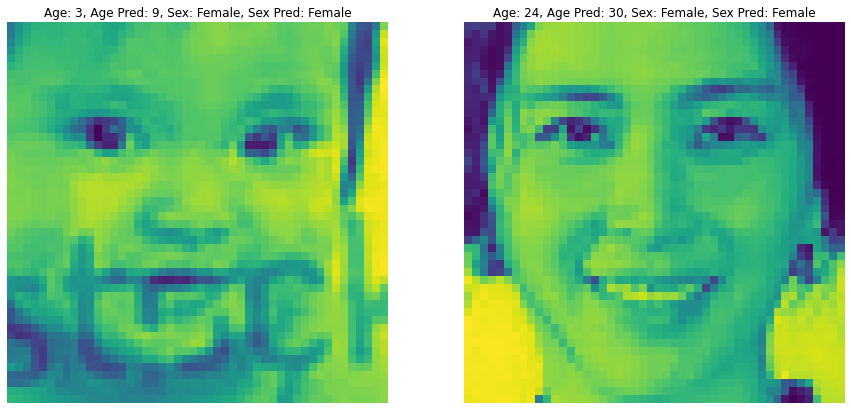

In [147]:
#visualizing our predictions versus the real age/gender
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

#choose 2 random pictures
for i in range(2):
    random_face = np.random.choice(len(df2))
    
    age = df2['age'][random_face]
    age_prediction = round(df2['age_pred'][random_face])
    gender = gender_list[df2['gender'][random_face]]
    gender_prediction = gender_list[round(df2['gender_pred'][random_face])]
    
    axes[i].set_title('Age: {0}, Age Pred: {1}, Sex: {2}, Sex Pred: {3}'.format(age, age_prediction, gender,gender_prediction))
    axes[i].imshow(X_test[random_face])
    axes[i].axis('off')

In [131]:
###################################################
##### saving the code below for deployment ########
###################################################


#gender_model.save('/Users/jeanphilippepetit-frere/Concordia bootcamp/final_project/processed-imdb-wiki-dataset/gender_cnn_model')

#age_model.save('/Users/jeanphilippepetit-frere/Concordia bootcamp/final_project/processed-imdb-wiki-dataset/age_cnn_model')

#df2.to_pickle('dataframe_predictions')

#np.save('X_test_array',X_test)

In [108]:
def predict_gender_age(filename):
    img1=image.load_img(filename)
    img2 = image.load_img(filename,target_size=(48,48))

    plt.imshow(img1)
 
    Y = image.img_to_array(img2)
    Y=cv2.cvtColor(Y, cv2.COLOR_BGR2GRAY)

    A = image.img_to_array(img2)
    A = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
    A = A/255
    Z = np.expand_dims(A,axis=0)
    X = np.expand_dims(Y,axis=0)
    val = gender_model.predict(X)
    age = age_model.predict(Z)
    print(round(age[0][0]))
    print(gender_list[round(val[0][0])])
    

60
Male


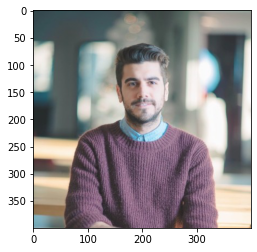

In [121]:
predict_gender_age('/Users/jeanphilippepetit-frere/Concordia bootcamp/final_project/test__/1612371224068.jpg')

78
Female


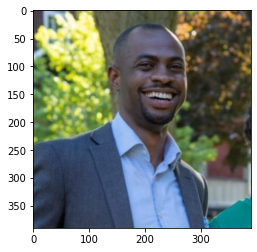

In [122]:
predict_gender_age('/Users/jeanphilippepetit-frere/Concordia bootcamp/final_project/test__/1607620882739.jpg')

63
Male


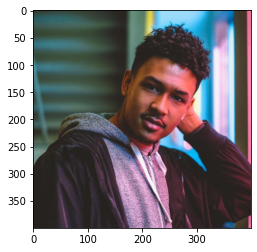

In [123]:
predict_gender_age('/Users/jeanphilippepetit-frere/Concordia bootcamp/final_project/test__/kaleb.jpg')